In [66]:
import os
import cv2
from matplotlib import pyplot as plt


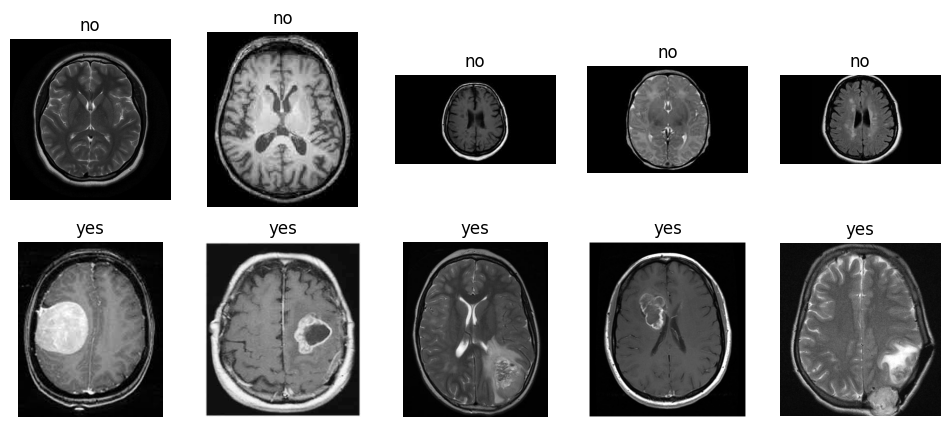

In [67]:
data_dir = "brain_tumor_dataset"

category = ["no", "yes"]


fig, axes = plt.subplots(2, 5, figsize=(12, 5))


for i, category in enumerate(category):
    path = os.path.join(data_dir, category)
    images = os.listdir(path)[:5]
    
    for j, image_name in enumerate(images):
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(category)
        axes[i, j].axis('off')
        